# Forest Cover Type Prediction
W207 Spring 2020

Elevation - Elevation in meters\
Aspect - Aspect in degrees azimuth (aspect denotes the compass direction in which the slope of a mountain faces)\
Slope - Slope in degrees (Slope is the steepness or the degree of incline of a surface)\
Horizontal_Distance_To_Hydrology - Horz Dist to nearest surface water features\
Vertical_Distance_To_Hydrology - Vert Dist to nearest surface water features\
Horizontal_Distance_To_Roadways - Horz Dist to nearest roadway\
Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice\
Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice\
Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice\
Horizontal_Distance_To_Fire_Points - Horz Dist to nearest wildfire ignition points\
Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation\
Soil_Type (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation\
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

## Import Libraries & Data

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

# SK-learn libraries for learning.
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from scipy import stats

In [10]:
# Data source: https://www.kaggle.com/c/forest-cover-type-prediction/overview
# Load data

train_path = '../data/train.csv'
# unlabeled_path = '../data/test.csv'
train_csv = np.genfromtxt(train_path, delimiter=',', names=True)
# unlabeled_csv = np.genfromtxt(unlabeled_path, delimiter=',', names=True)

# Extract feature and label strings
all_headers = train_csv.dtype.names
feature_name = train_csv.dtype.names[:-1]
label_name = set(train_csv['Cover_Type'])

## Summary Statistics

In [11]:
df = pd.DataFrame(train_csv, columns=[i for i in all_headers])
stat_summary = df.describe().T
stat_summary

,count,mean,std,min,25%,50%,75%,max
Id,15120.0,7560.500000,4364.912370,1.0,3780.75,7560.5,11340.25,15120.0
Elevation,15120.0,2749.322553,417.678187,1863.0,2376.00,2752.0,3104.00,3849.0
Aspect,15120.0,156.676653,110.085801,0.0,65.00,126.0,261.00,360.0
Slope,15120.0,16.501587,8.453927,0.0,10.00,15.0,22.00,52.0
Horizontal_Distance_To_Hydrology,15120.0,227.195701,210.075296,0.0,67.00,180.0,330.00,1343.0
Vertical_Distance_To_Hydrology,15120.0,51.076521,61.239406,-146.0,5.00,32.0,79.00,554.0
Horizontal_Distance_To_Roadways,15120.0,1714.023214,1325.066358,0.0,764.00,1316.0,2270.00,6890.0
Hillshade_9am,15120.0,212.704299,30.561287,0.0,196.00,220.0,235.00,254.0
Hillshade_Noon,15120.0,218.965608,22.801966,99.0,207.00,223.0,235.00,254.0
Hillshade_3pm,15120.0,135.091997,45.895189,0.0,106.00,138.0,167.00,248.0


In [12]:
# Distribution of cover types
df.groupby('Cover_Type').size()

Cover_Type
1.0    2160
2.0    2160
3.0    2160
4.0    2160
5.0    2160
6.0    2160
7.0    2160
dtype: int64

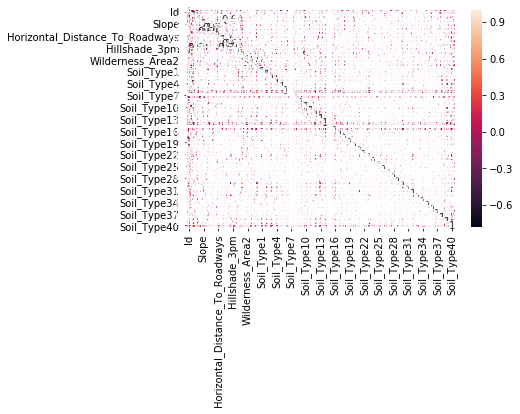

In [13]:
# Check correlation between features

df_corr = df.drop(['Cover_Type'], axis=1)
corrMatrix = df_corr.corr()
sn.heatmap(corrMatrix, annot=True)

In [14]:
# Top ten correlations
c = corrMatrix.unstack().abs()
c[c!=1].sort_values(ascending = False)[:10]

Wilderness_Area4                  Elevation                           0.783651
Elevation                         Wilderness_Area4                    0.783651
Hillshade_9am                     Hillshade_3pm                       0.779965
Hillshade_3pm                     Hillshade_9am                       0.779965
Horizontal_Distance_To_Hydrology  Vertical_Distance_To_Hydrology      0.652142
Vertical_Distance_To_Hydrology    Horizontal_Distance_To_Hydrology    0.652142
Hillshade_3pm                     Aspect                              0.635022
Aspect                            Hillshade_3pm                       0.635022
Hillshade_Noon                    Hillshade_3pm                       0.614526
Hillshade_3pm                     Hillshade_Noon                      0.614526
dtype: float64

**Learning:**
- All features have 15120 observations so no missing data. All features could be used.
- 'Id', 'Soil_Type7', and 'Soil_Type15' has no meaningful data based on summary statistics. Will drop from datasets
- Negative values for Vertical_Distance_To_Hydrology
- One hot encoding (a single high bit and all the others low) for Wilderness Area and Soil Type
- Balanced distribution of cover types (2160 each)
- There are some correlations among features, possibly potential to reduce feature set through transformation or PCA

## Preprocessing (first attempt)

In [85]:
# # Function to rescale bounded, continuous features: All continuous input that are bounded, rescale them to [-1, 1].  x = (2x - max - min)/(max - min)
# def rescale(feature, minimum, maximum):
#     return (feature * 2 - minimum - maximum) / (maximum - minimum)

# # Standardize all continuous features: x = (x - mean)/stdev
# def standardize(feature, mean, stdev):
#     return (feature - mean) / stdev

# bounded_features = ['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']
# bounded_min_max = [(0, 360), (0,90), (0, 255), (0, 255), (0, 255)]

# continuous_features = ['Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 
#                        'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']
# continuous_mean_std = [(stat_summary.loc[i, 'mean'], (stat_summary.loc[i, 'std'])) for i in continuous_features]

# # Create new columns for rescaled features
# for i, j in enumerate(bounded_features):
#     # Create new rescaled column for bounded features
#     df[j.lower() + "_RS"] = rescale(df[j], bounded_min_max[i][0], bounded_min_max[i][1])

# # Create new columns for standardized features    
# for m, n in enumerate(continuous_features):
#     # Create new standardize column for continuous features
#     df[n.lower() + "_RS"] = standardize(df[n], continuous_mean_std[m][0], continuous_mean_std[m][1])

# excluded_columns = ['Id', 'Soil_Type7', 'Soil_Type15'] + bounded_features + continuous_features

# df = df[[c for c in df.columns if c not in excluded_columns]]

# # Split df: labels, binary, and non-binary
# labels = df.pop("Cover_Type").to_numpy()
# non_binary_features = [s for s in df.columns if "_RS" in s]
# binary_features = [[s for s in df.columns if "_RS" not in s]]

## Preprocessing (second attempt)

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

In [15]:
# Exclude columns with no useful data for prediction
new_headers = [n for n in all_headers if n not in ['Id', 'Soil_Type7', 'Soil_Type15']]
df = df[new_headers]

In [51]:
# Extract only the values
array = df.values

# Y = target column, X = features
X = array[:,0:-1]
Y = array[:,-1]

In [67]:
# dfs' from transformation
df_all = []

# No transformations
df_all.append(['Orig',X])

#Standardized
#Apply transform only for non-categorical data
df_temp = StandardScaler().fit_transform(X[:,0:10])
#Concatenate non-categorical data and categorical
df_con = np.concatenate((df_temp,X[:,10:]),axis=1)
#Add this version of df to the list 
df_all.append(['StdScaler',df_con])

#MinMax
#Apply transform only for non-categorical data
df_temp = MinMaxScaler().fit_transform(X[:,0:10])
#Concatenate non-categorical data and categorical
df_con = np.concatenate((df_temp,X[:,10:]),axis=1)
#Add this version of df to the list 
df_all.append(['MinMax',df_con])

#Normalize
#Apply transform only for non-categorical data
df_temp = Normalizer().fit_transform(X[:,0:10])
#Concatenate non-categorical data and categorical
df_con = np.concatenate((df_temp,X[:,10:]),axis=1)
#Add this version of df to the list 
df_all.append(['Normalizer',df_con])

#### Split 70/20/10

In [70]:
# Sets of train/dev/test with various preprocessing
# by index: 0(no transform), 1(standard scaler), 2(minmax), 3(normalize)
TrainDevTest_Sets = []

# Train, dev, test split (70/20/10)
split1 = int(len(df)* 0.70)
split2 = int(split1 + (len(train_csv) - split1) * 2 / 3)


for X_array in df_all:
    train_data, train_labels = X_array[1][:split1,:], Y[:split1]
    dev_data, dev_labels     = X_array[1][split1:split2,:], Y[split1:split2]
    test_data, test_labels   = X_array[1][split2:,:], Y[split2:]
    TrainDevTest_Sets.append([X_array[0], train_data, train_labels, dev_data, dev_labels, test_data, test_labels])

print('training shape:', TrainDevTest_Sets[0][1].shape)
print('dev shape:',      TrainDevTest_Sets[0][3].shape)
print('test shape:',     TrainDevTest_Sets[0][5].shape)
print('labels names:',         label_name)
print('number of features:',   TrainDevTest_Sets[0][1].shape[1])

training shape: (10584, 52)
dev shape: (3024, 52)
test shape: (1512, 52)
labels names: {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0}
number of features: 52


## Feature Selection (Random Forest Classifier)

In [86]:
# Function to find the rank of features based on training data and feature selection method

def FindFeatureRank(X, Y, sel, name):
    sel.fit(X, Y)
    # Numeric weight of importance (greater value = higher importance)
    feature_importance = sel.estimator_.feature_importances_.tolist()
    seq = sorted(feature_importance, reverse=True)
    # Rank of each feature, maintain ordering of array
    rank = [seq.index(v) for v in feature_importance]
    # Chosen feature names (importance above mean)
    selected_feature = df.iloc[:,:-1].columns[sel.get_support()]
    
    return [name, rank, selected_feature]

# Empty array to append to for each feature selection
MethodRankSelected = []

In [87]:
# Random Forest Classifier
# Add rank and info for each transformation type for RF classifier
for n in TrainDevTest_Sets:
    train_data, train_labels = n[1], n[2]
    sel = SelectFromModel(RandomForestClassifier(n_estimators=52, random_state=0, n_jobs=-1))
    MethodRankSelected.append(FindFeatureRank(train_data, train_labels, sel, n[0] + " RF"))

## Feature Selection (Recursive Feature Elimination)

In [96]:
from sklearn.feature_selection import RFE
# Recursive Feature Elimination
# Add rank and info for each transformation type for RFE classifier
for n in TrainDevTest_Sets:
    train_data, train_labels = n[1], n[2]
    sel = RFE(RandomForestClassifier(n_estimators=52, random_state=0, n_jobs=-1), n_features_to_select=15)
    MethodRankSelected.append(FindFeatureRank(train_data, train_labels, sel, n[0] + " RFE"))

In [95]:
for i in MethodRankSelected:
    print()
    print("Feature Names Selection For {} transformation: ".format(i[0]))
    print(i[2])
    print()
    print("Feature Rank Selection For {} transformation: ".format(i[0]))
    print(i[1])


Feature Names Selection For Orig RF transformation: 
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area4', 'Soil_Type10',
       'Soil_Type38'],
      dtype='object')

Feature Rank Selection For Orig RF transformation: 
[0, 7, 10, 3, 5, 1, 6, 9, 8, 2, 15, 29, 16, 4, 34, 26, 14, 19, 37, 28, 50, 47, 11, 31, 22, 21, 40, 38, 27, 39, 42, 35, 46, 24, 20, 32, 51, 43, 45, 49, 23, 18, 33, 25, 30, 44, 36, 48, 41, 12, 13, 17]

Feature Names Selection For StdScaler RF transformation: 
Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area4', 'Soil_Type10',
       'So

## Random Forest

In [102]:
def RandomForest(x_train, x_dev, y_train, y_dev):
    rf = RandomForestClassifier(n_estimators=52, random_state=0, n_jobs=1)
    rf.fit(x_train, y_train)
    model_pred = rf.predict(x_dev)
    rf_acc = metrics.f1_score(y_dev, model_pred, average="weighted")
    print("The f1 score for RF is {}".format(rf_acc))

In [115]:
# Without feature selection
RandomForest(train_data, dev_data, train_labels, dev_labels)

# With RF feature selection
RandomForest(train_data_RF, dev_data_RF, train_labels_RF, dev_labels_RF)

# With RFE feature selection
RandomForest(train_data_RFE, dev_data_RFE, train_labels_RFE, dev_labels_RFE)

The f1 score for RF is 0.8093219846646126
The f1 score for RF is 0.7795404916829198
The f1 score for RF is 0.8163944239059411


## KNN

In [118]:
# k-NN

# search for an optimal value of K for KNN
k_range = [1,4,7,10]

# list of scores from k_range
f1_scores = []

def KNN(k):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_data, train_labels)
    model_pred = model.predict(dev_data)
    return model_pred

for k in k_range:
    score = metrics.f1_score(dev_labels, KNN(k), average="weighted")
    f1_scores.append(score)
    print("The f1 score for {}-NN is {}".format(k, score))


The f1 score for 1-NN is 0.7557477916049917
The f1 score for 4-NN is 0.7352886099252398
The f1 score for 7-NN is 0.7181820525124354
The f1 score for 10-NN is 0.7111317517786139


## Naive Bayes

ideas from:  
https://stackoverflow.com/questions/14254203/mixing-categorial-and-continuous-data-in-naive-bayes-classifier-using-scikit-lea

https://stackoverflow.com/questions/14274771/choosing-classification-algorithm-to-classify-mix-of-nominal-and-numeric-data?rq=1

https://stackoverflow.com/questions/32707914/different-types-of-features-to-train-naive-bayes-in-python-pandas

handling discrete + continous:  
https://www.quora.com/Machine-Learning/What-are-good-ways-to-handle-discrete-and-continuous-inputs-together/answer/Arun-Iyer-1

In [98]:
# Evaluate binary features and continuous features indepedently (Naive assumption means no correlation between features taken into account anyways)

# BernoulliNB (Binary features only)
train_data_binary = train_data[:,:-10]
dev_data_binary = dev_data[:,:-10]

bnb = BernoulliNB(alpha=1)
bnb.fit(train_data_binary, train_labels)
model_pred = bnb.predict(dev_data_binary)
acc_bnb = metrics.f1_score(dev_labels, model_pred, average="weighted")
print("BernoulliNB model accuracy using binary features only:", acc_bnb)

bnb.predict(dev_data_binary)

BernoulliNB model accuracy using binary features only: 0.48760947746407673


array([1., 5., 7., ..., 5., 5., 5.])

In [120]:
# GaussianNB (Continuous features only)
train_data_cont = train_data[:,-10:]
dev_data_cont= dev_data[:,-10:]

gnb = GaussianNB() 
gnb.fit(train_data_cont, train_labels)
model_pred = gnb.predict(dev_data_cont)
acc_gnb = metrics.f1_score(dev_labels, model_pred, average="weighted")
print("GaussianNB model accuracy using continous features only:", acc_gnb)

GaussianNB model accuracy using continous features only: 0.27988823906528076


C:\Users\Hien\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [73]:
print(bnb.predict_proba(dev_data_binary)[0])
print(gnb.predict_proba(dev_data_cont)[0])

gnb.predict_proba(dev_data_cont)[0] * bnb.predict_proba(dev_data_binary)[0]

[2.24414207e-01 2.16053953e-01 3.86938692e-02 8.85156042e-05
 2.28525380e-01 6.36986956e-02 2.28525380e-01]
[2.40323569e-01 4.36530101e-02 9.85504611e-12 1.55703701e-37
 1.08666966e-09 4.10455489e-10 7.16023419e-01]


array([5.39320232e-02, 9.43140540e-03, 3.81329865e-13, 1.37822072e-41,
       2.48331596e-10, 2.61454793e-11, 1.63629524e-01])

**Improvement ideas:**

Preprocessing:
1. Rescaling bounded features and standardizing continuous features
2. Feature selection

Modeling:
1. Create new features vector from the class assignment probabilities {np.hstack((bernoulli and gaussian))}. Then run another GaussianNB fit on the new features
2. Create function to calculate merged feature probabilities (product of Bernoulli and Gaussian) since we calculate the Bayes probability independently on a specific features